In [10]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

sns.set_style('whitegrid')
sns.set_palette('Set2')
sns.color_palette('Set2')
dlsu_green = "#117a65ff"

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [3]:
churn_df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
model_data = churn_df.copy(deep=True)

#remove customerId column from the model data
model_data.drop("customerID", inplace=True, axis=1)
#convert gender to numeric
model_data.gender = model_data.gender.apply(lambda x: 1 if x == 'Female' else 0)
#convert SeniorCitizen, Partner, Dependents, PhoneService, PaperlessBilling, Churn & etc
for c in ['SeniorCitizen', 'Partner', 
          'Dependents', 'PhoneService', 
          'PaperlessBilling', 'Churn',
          'MultipleLines', 'OnlineSecurity',
          'OnlineBackup', 'DeviceProtection',
          'TechSupport', 'StreamingTV',
          'StreamingMovies']:
    model_data[c] = model_data[c].apply(lambda x: 1 if x == 'Yes' else 0) 

#convert TotalCharges to float
model_data.TotalCharges = pd.to_numeric(model_data.TotalCharges, errors='coerce')
model_data.TotalCharges = model_data.TotalCharges.fillna(value=-1)

#one hot encode features with multiple categories 
multi_categorical_features = ['InternetService', 'Contract', 'PaymentMethod']
enc = OneHotEncoder(handle_unknown='ignore')
res = enc.fit_transform(model_data[multi_categorical_features])
res_df = pd.DataFrame(res.todense(), columns=enc.get_feature_names())

model_data.drop(multi_categorical_features, axis=1, inplace=True)
model_data = pd.concat([model_data, res_df], axis=1)

model_data.head()

C:\ProgramData\Anaconda3\envs\DATA102\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,x0_DSL,x0_Fiber optic,x0_No,x1_Month-to-month,x1_One year,x1_Two year,x2_Bank transfer (automatic),x2_Credit card (automatic),x2_Electronic check,x2_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0,0,0,34,1,0,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0,0,0,0,2,1,0,1,1,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0,0,0,45,0,0,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1,0,0,0,2,1,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
X = model_data.drop("Churn", axis=1) #store to X the features used for modeling (independent variables)
y = model_data["Churn"]#store to y our target (dependent variable)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Stacking Method via Sklearn

Sklearn has the `VotingClassifier` and `VotingRegressor` class available to do the stacking method. Using these classes a majority vote is done to predict classification problems while the average forecasts from the different models is used for regression problems.

In [7]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingRegressor

### Create a logistic regression and knn model using grid search

In [17]:
from sklearn.metrics import  make_scorer
param_grid1 = {
    'C': [0.1, 0.001, 0.0001, 1, 10, 100],
    'penalty': ['l1','l2']
}

scorers1 = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}

model1 = LogisticRegression(solver='liblinear')
search = GridSearchCV(model1, param_grid1, scoring=scorers1, refit='f1_score', verbose=1, cv =10)

best_model = search.fit(X_train, y_train)

clf1 = best_model.best_estimator_ 

param_grid2 = {
    'n_neighbors': range(1,11),
    'p': [1,2]
}

model2 = KNeighborsClassifier()
search2 = GridSearchCV(model2, param_grid2, scoring=scorers1, refit='f1_score', verbose=1, cv=10)
best_model2 = search2.fit(X_train, y_train)
clf2 = best_model2.best_estimator_

a = clf1.score(X_test, y_test)
b = clf2.score(X_test,y_test)
print(a,b)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


C:\ProgramData\Anaconda3\envs\DATA102\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\DATA102\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\DATA102\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\DATA102\lib\site-packages\sklearn\metrics\_classi

Fitting 10 folds for each of 20 candidates, totalling 200 fits
0.8116422148603881 0.7714150496923805


### Print Test Accuracy for Logistic Regression and KNN 

### Use Voting Classifer for the best models from KNN and Logistic Regression

In [23]:
lr_model = LogisticRegression(solver='liblinear')
knn_model = KNeighborsClassifier()

eclf = VotingClassifier(estimators=[('lr', lr_model), ('knn', knn_model)])
eclf.fit(X_train, y_train)


VotingClassifier(estimators=[('lr', LogisticRegression(solver='liblinear')),
                             ('knn', KNeighborsClassifier())])

In [24]:
eclf.score(X_test,y_test)

0.7903454803596782

using gridsearch with the VotingClassifier

In [25]:
param_grid = {'lr__C': [0.1, 1, 10],
              "lr__penalty": ["l1", "l2"], 
              "lr__solver": ["liblinear"],
              "knn__n_neighbors": range(5,20)
             }

eclf = VotingClassifier(estimators=[('lr', LogisticRegression()), ('knn', KNeighborsClassifier())])
eclf_grid = GridSearchCV(eclf, param_grid)
eclf_grid.fit(X_train, y_train)


GridSearchCV(estimator=VotingClassifier(estimators=[('lr',
                                                     LogisticRegression()),
                                                    ('knn',
                                                     KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': range(5, 20),
                         'lr__C': [0.1, 1, 10], 'lr__penalty': ['l1', 'l2'],
                         'lr__solver': ['liblinear']})

## Bagging Method with Random Forest

These are a few hyperparameters that we can tune when using Random Forest.

- n_estimators: # of estimators in the forest, default is 100
- max_depth: max depth of the trees in the forest, default is to expand until all leaves are pure 
- min_sample_split: The minimum number of samples required to split an internal node:
- min_samples_leaf: The minimum number of samples required to be at a leaf node.
- max_features: The number of features to consider when looking for the best split:


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

In [27]:
param_grid = {
    "n_estimators": range(100, 150, 10),
    "max_depth": range(5,50,5),
    "min_samples_split": np.arange(.1,.6,.1),
    "min_samples_leaf": np.arange(.1,.6,.1),
    "max_features": np.arange(0.1, 0.6, .1)
}

clf = RandomForestClassifier()
clf_grid = RandomizedSearchCV(clf, param_grid, n_iter=25)
clf_grid.fit(X_train, y_train)


RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=25,
                   param_distributions={'max_depth': range(5, 50, 5),
                                        'max_features': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                                        'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                                        'min_samples_split': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                                        'n_estimators': range(100, 150, 10)})

### Plot feature importance for Random Forest

<AxesSubplot:xlabel='importance', ylabel='feature'>

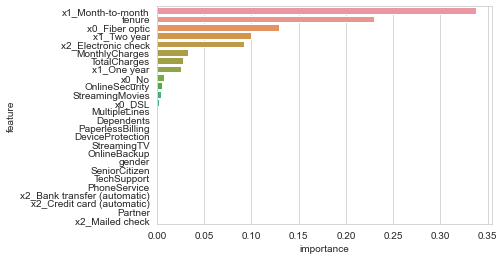

In [28]:
feat_df = pd.DataFrame()
feat_df['feature'] = X_train.columns
feat_df['importance'] = clf_grid.best_estimator_.feature_importances_
feat_df = feat_df.sort_values('importance', ascending=False)
sns.barplot(y=feat_df['feature'], 
            x=feat_df['importance'])

## Boosting Method with XGB

XGBoost is not readily available in Scikitlearn so we have to install it separately. You have to run this command to install it.

In [31]:
! pip3 install xgboost


These are a few hyperparameters commonly used for tuning XGBoost

- n_estimators: specifies the number of decision trees to be boosted. The default value is 100.
- subsample: the subsample ratio of the training sample. Example a subsample of .5 means that 50% of training data is used prior to growing a tree. 
- max_depth: Limits the depth of the tree. The default value is 6.
- learning_rate (alias: eta): Regularization parameter that shrinks feature weights in each boosting step. The default value is 0.3.
- gamma (alias: min_split_loss): it’s another regularization parameter for tree pruning. It specifies the minimum loss reduction required to grow a tree. The default value is set at 0.
- reg_alpha (alias: alpha): it is the L1 regularization parameter, increasing its value makes the model more conservative. Default is 0.
- reg_lambda (alias: lambda): L2 regularization parameter, increasing its value also makes the model conservative. Default is 1.

<a href="https://towardsdatascience.com/a-guide-to-xgboost-hyperparameters-87980c7f44a9">Source from Alam M.</a>

In [32]:
import xgboost as xgb

For XGBoost to be able to read our data it needs to be places inside a DMatrix object. This is an optimized data stucture used for memory management and training speed enhancement. 

In [33]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
params = {
    'n_estimators': range(100, 500, 50),
    'max_depth': range(5,50,5),
    'learning_rate': [0.0001, 0.001, 0.1, 1],
    'gamma': np.arange(0.5, 2, .2),
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 3, 4.5],
}

clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric="logloss",  use_label_encoder=False)
clf_grid = RandomizedSearchCV(clf, params, n_iter=250)
clf_grid.fit(X_train, y_train)

In [ ]:
clf_grid.best_estimator_.score(X_test, y_test)

In [ ]:
feat_df = pd.DataFrame()
feat_df['feature'] = X_train.columns
feat_df['importance'] = clf_grid.best_estimator_.feature_importances_
feat_df = feat_df.sort_values('importance', ascending=False)
sns.barplot(y=feat_df['feature'], 
            x=feat_df['importance'])